In [90]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
#from pandas_profiling import ProfileReport
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline

# Carregando os dados

In [91]:
df = pd.read_csv('../input/renner_desafio_pucrs_treino.csv')
df.head()

,item,cod_loja,semana_comercial,data_semana_comercial,venda,categoria_loja,localidade,loja_tamanho,clima
0,100342,58,202130,2021-07-25,51,fisica,br,G,RIO
1,100342,63,202221,2022-05-22,86,fisica,br,G,RIO
2,100342,84,202131,2021-08-01,62,fisica,br,G,RIO
3,100342,2,202222,2022-05-29,171,fisica,br,G,SUL
4,100342,407,202223,2022-06-05,188,web,br,GG,W


# Explorando os dados

In [ ]:
#Gerando o Profile Report
#profile = ProfileReport(df)
#profile.to_file('profile_output.html')

In [51]:
df.shape

(92877, 9)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92877 entries, 0 to 92876
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   item                   92877 non-null  int64 
 1   cod_loja               92877 non-null  int64 
 2   semana_comercial       92877 non-null  int64 
 3   data_semana_comercial  92877 non-null  object
 4   venda                  92877 non-null  int64 
 5   categoria_loja         92877 non-null  object
 6   localidade             92877 non-null  object
 7   loja_tamanho           92877 non-null  object
 8   clima                  92877 non-null  object
dtypes: int64(4), object(5)
memory usage: 6.4+ MB


In [54]:
df.isna().sum()

item                     0
cod_loja                 0
semana_comercial         0
data_semana_comercial    0
venda                    0
categoria_loja           0
localidade               0
loja_tamanho             0
clima                    0
dtype: int64

In [55]:
df.describe()

,item,cod_loja,semana_comercial,venda
count,92877.0,92877.000000,92877.000000,92877.000000
mean,100342.0,176.024742,201975.466036,26.485158
std,0.0,107.675970,163.395399,71.062728
min,100342.0,1.000000,201701.000000,-4.000000
25%,100342.0,84.000000,201831.000000,5.000000
50%,100342.0,170.000000,201951.000000,14.000000
75%,100342.0,260.000000,202123.000000,30.000000
max,100342.0,420.000000,202234.000000,5476.000000


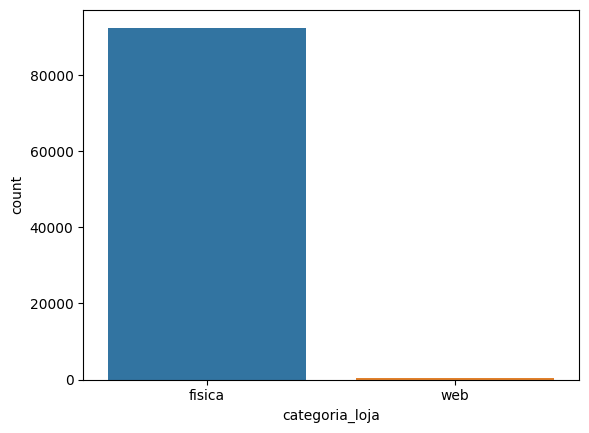

In [60]:
#Quantidade de lojas fisicas e lojas web
sns.countplot(x='categoria_loja', data=df)
plt.show()

<AxesSubplot: xlabel='categoria_loja', ylabel='venda'>

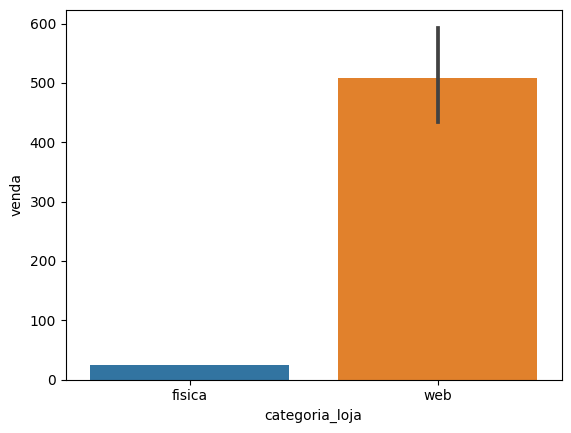

In [61]:
#Quantidade de venda por cat. de loja
sns.barplot(x='categoria_loja', y='venda', data=df)

In [65]:
#Veficando valores máximos e mínios
print(df['venda'].min())
print(df['venda'].max())

-4
5476


In [63]:
df[df['venda'] < 0]

,item,cod_loja,semana_comercial,data_semana_comercial,venda,categoria_loja,localidade,loja_tamanho,clima
900,100342,12,201743,2017-10-22,-1,fisica,br,G,SUL
1596,100342,321,201943,2019-10-27,-2,fisica,br,P,SPO
1791,100342,270,202007,2020-02-16,-1,fisica,br,M,SUL
1837,100342,273,202138,2021-09-19,-2,fisica,br,P,RIO
1983,100342,111,202203,2022-01-16,-1,fisica,br,M,RIO
...,...,...,...,...,...,...,...,...,...
92827,100342,58,202001,2020-01-05,-1,fisica,br,G,RIO
92846,100342,323,202145,2021-11-07,-1,fisica,br,P,NOR
92850,100342,171,201826,2018-07-01,-1,fisica,br,P,SPO
92858,100342,312,201745,2017-11-05,-1,fisica,br,M,SUL


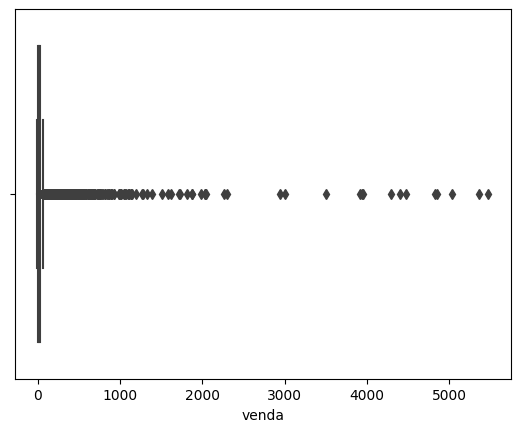

In [64]:
sns.boxplot(x=df['venda'])
plt.show()

## Insights/anotações iniciais


*   Sem dados nulos, faltantes ou duplicados;
*   Colunas desnecessárias para o treinamento (dropar): Item, semana_comercial (recomendação do Hollisson);
*   Garantir que exista 1 linha por item, loja e data_semana_comercial (recomendação do Hollisson);
*   Possuimos somente duas lojas web, mas mesmo assim a quantidade de venda é muito maior do que a venda nas lojas físicas. Talvez, seja interessante separar modelos diferentes para cada tipo de loja;
*   Lojas web: cod 406 e 407 - todas tem: localidade = br, tamanho = gg, clima = w
*   Temos linhas com a quantidade de venda negativa (520 de 92877), fazer o tratamento;


# Tratamentos inicias
1 - Dropar colunas desnecessárias: 'item', 'semana_comercial' <br>
2 - Removendo linhas com vendas 'GS' (Guide Shop)<br>
3 - Alterar valores negativos de venda para zero (verificar onde os zeros estao distribuidos no dataset)<br>
4 - Alterar variaveis categóricas para variaveis numéricas<br>
5 - Transformar 'data_semana_comercial' para datetime e colocar como índice<br>
--------------------------------------------------------------------------------------<br>
4 - Tratar linhas duplicadas após dropar 'semana_comercial' (Garantir uma linha por item, loja e data_semana_comercial)<br>
7 - Separar entre dataset de treino para loja fisica e web<br>
8 - Dropas colunas desnecessárias para o dataset web<br>

In [92]:
#1
df.drop(['item', 'semana_comercial'], axis=1, inplace=True)
df.head()

,cod_loja,data_semana_comercial,venda,categoria_loja,localidade,loja_tamanho,clima
0,58,2021-07-25,51,fisica,br,G,RIO
1,63,2022-05-22,86,fisica,br,G,RIO
2,84,2021-08-01,62,fisica,br,G,RIO
3,2,2022-05-29,171,fisica,br,G,SUL
4,407,2022-06-05,188,web,br,GG,W


In [93]:
#2
df = df.loc[df['clima'] != 'GS']
df.shape

(92814, 7)

In [94]:
#3
df.loc[df.venda < 0, 'venda'] = 0

In [112]:
zero = df[df['venda'] == 0]

In [115]:
zero['localidade'].value_counts()

2    1032
1       7
0       1
Name: localidade, dtype: int64

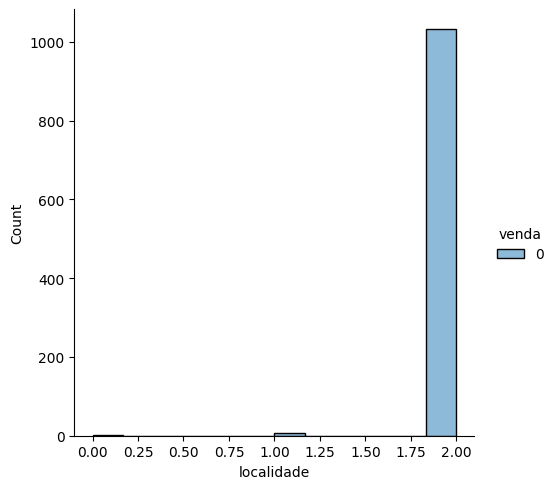

In [113]:
sns.displot(zero, x="localidade", hue="venda")

ValueError: Unable to parse string "W" at position 859

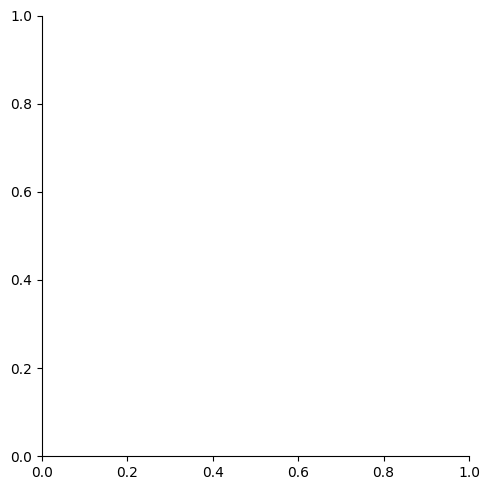

In [119]:
sns.displot(zero, x="clima", hue="venda")

In [96]:
#4
df['localidade'] = df['localidade'].map({ 'br':2, 'uy':1, 'ar':0 })
df['loja_tamanho'] = df['loja_tamanho'].map({ 'PP':0, 'P':1, 'M':2, 'G':3, 'GG':4 })
df['clima'] = df['clima'].map({ 'SPO':5, 'RIO':4, 'NOR':3, 'SUL':2 ,'URU':1 ,'ARG': 0, 'W':'W'})

In [99]:
#5
date = pd.to_datetime(df['data_semana_comercial'])
df.index = date

In [101]:
df.head()

,cod_loja,data_semana_comercial,venda,categoria_loja,localidade,loja_tamanho,clima
data_semana_comercial,,,,,,,
2021-07-25,58,2021-07-25,51,fisica,2,3,4
2022-05-22,63,2022-05-22,86,fisica,2,3,4
2021-08-01,84,2021-08-01,62,fisica,2,3,4
2022-05-29,2,2022-05-29,171,fisica,2,3,2
2022-06-05,407,2022-06-05,188,web,2,4,W


In [76]:
df_agrupado = df.groupby('data_semana_comercial').agg(
                                                    {'venda': 'sum', 
                                                    'cod_loja': 'first', 
                                                    'categoria_loja': 'first', 
                                                    'localidade': 'first', 
                                                    'loja_tamanho': 'first', 
                                                    'clima': 'first'}).reset_index()

In [78]:
df_agrupado.head()

,data_semana_comercial,venda,cod_loja,categoria_loja,localidade,loja_tamanho,clima
0,2017-01-01,384,47,fisica,br,M,SPO
1,2017-01-08,344,150,fisica,br,G,RIO
2,2017-01-15,289,132,fisica,br,P,SUL
3,2017-01-22,305,43,fisica,br,M,SPO
4,2017-01-29,848,67,fisica,br,M,SUL


In [81]:
df_agrupado.shape

(295, 7)